# Trabajo Práctico 2

Karen Raczkowski

In [17]:
import numpy as np
import scipy.fftpack as fft
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Implementar la función create_gauss_filter (h, w, k_size) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [18]:
# Cargar la imagen
img = cv2.imread("./cameraman.png", cv2.IMREAD_GRAYSCALE)
h = img.shape[0]
w = img.shape[1]
print("Tamaño de la imagen:", h, "x", w)

Tamaño de la imagen: 256 x 256


In [19]:
def create_gauss_filter(h, w, k_size, sigma):
    # Generación del kernel gaussiano
    kernel = cv2.getGaussianKernel(ksize=k_size, sigma=sigma)
    gaussian_kernel = kernel * kernel.T
    
    # Padding generation
    h_pad_top, h_pad_bottom = (h - k_size) // 2, (h - k_size) - (h - k_size) // 2
    w_pad_left, w_pad_right = (w - k_size) // 2, (w - k_size) - (w - k_size) // 2
    gauss_kernel_padded = np.pad(gaussian_kernel, ((h_pad_top, h_pad_bottom), (w_pad_left, w_pad_right)), mode='constant')
    
    # Fourier Transform for the Kernel
    filter_frequency = np.fft.fft2(gauss_kernel_padded)

    return gauss_kernel_padded, filter_frequency

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro a una imagen para validar el funcionamiento en el dominio espectral.

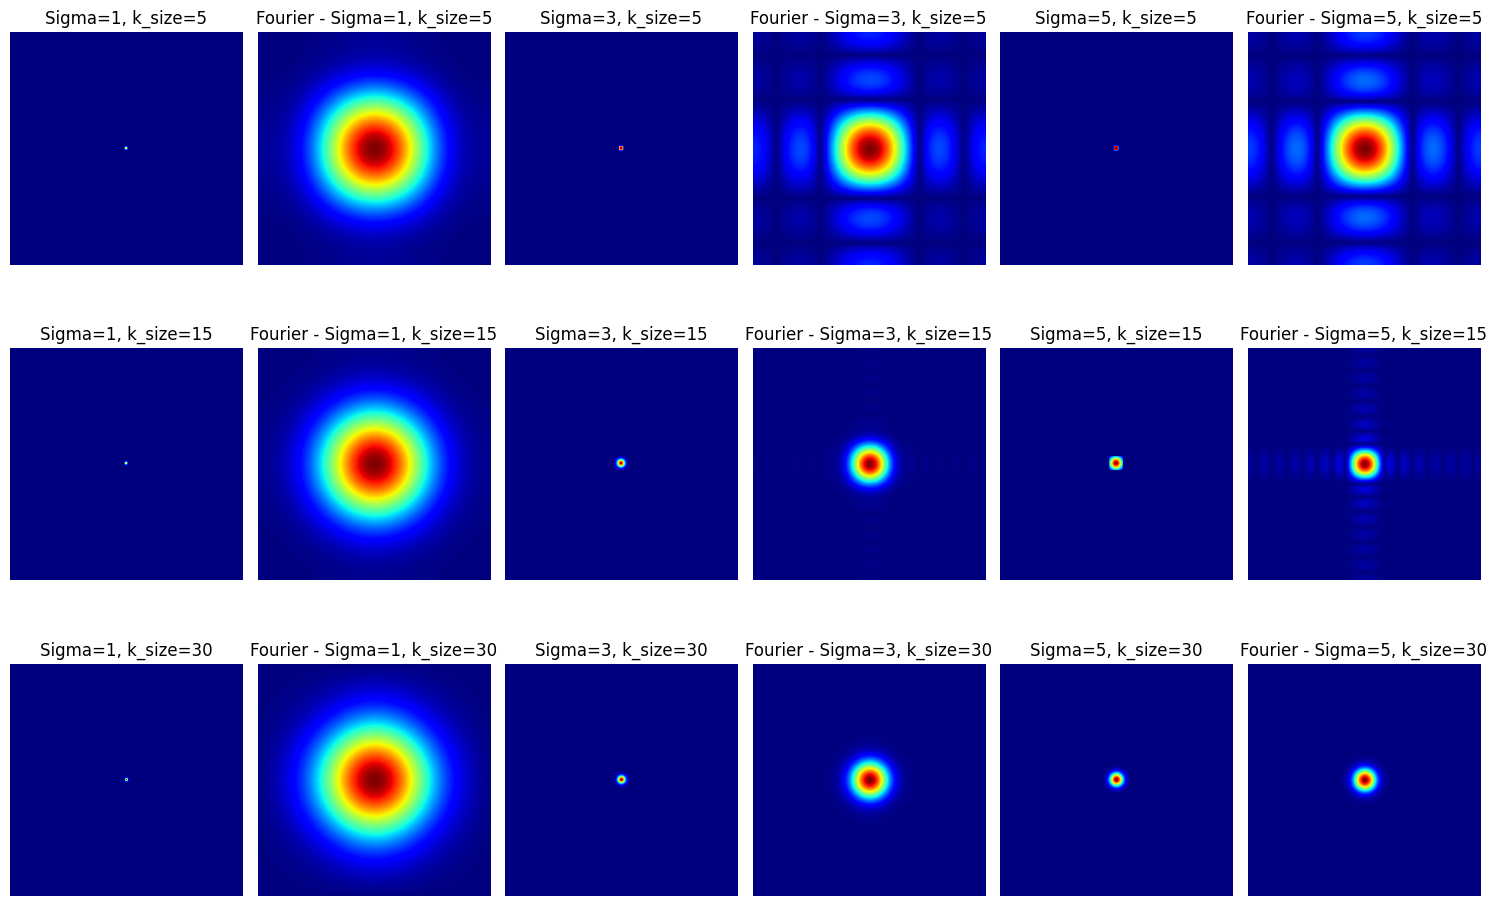

In [20]:
# Valores de k_sizes y sigmas que se probarán
k_sizes = [5, 15, 30]
sigmas = [1, 3, 5]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 10))

# Aplicar el filtro gaussiano con diferentes k_sizes y sigmas
for i, k_size in enumerate(k_sizes):
    for j, sigma in enumerate(sigmas):
        # Crear el filtro gaussiano y su transformada de Fourier
        kernel, kernel_tf = create_gauss_filter(h, w, k_size, sigma)
        
        # Graficar el filtro gaussiano en el dominio espacial
        plt.subplot(len(k_sizes), 2 * len(sigmas), 2 * i * len(sigmas) + 2 * j + 1)
        plt.imshow(kernel, cmap='jet')
        plt.title(f'Sigma={sigma}, k_size={k_size}')
        plt.axis('off')

        # Graficar la Transformada de Fourier del filtro gaussiano
        plt.subplot(len(k_sizes), 2 * len(sigmas), 2 * i * len(sigmas) + 2 * j + 2)  
        tf_shifted = np.fft.fftshift(kernel_tf)
        plt.imshow(np.abs(tf_shifted), cmap='jet')
        plt.title(f'Fourier - Sigma={sigma}, k_size={k_size}')
        plt.axis('off')

plt.tight_layout()
plt.show()

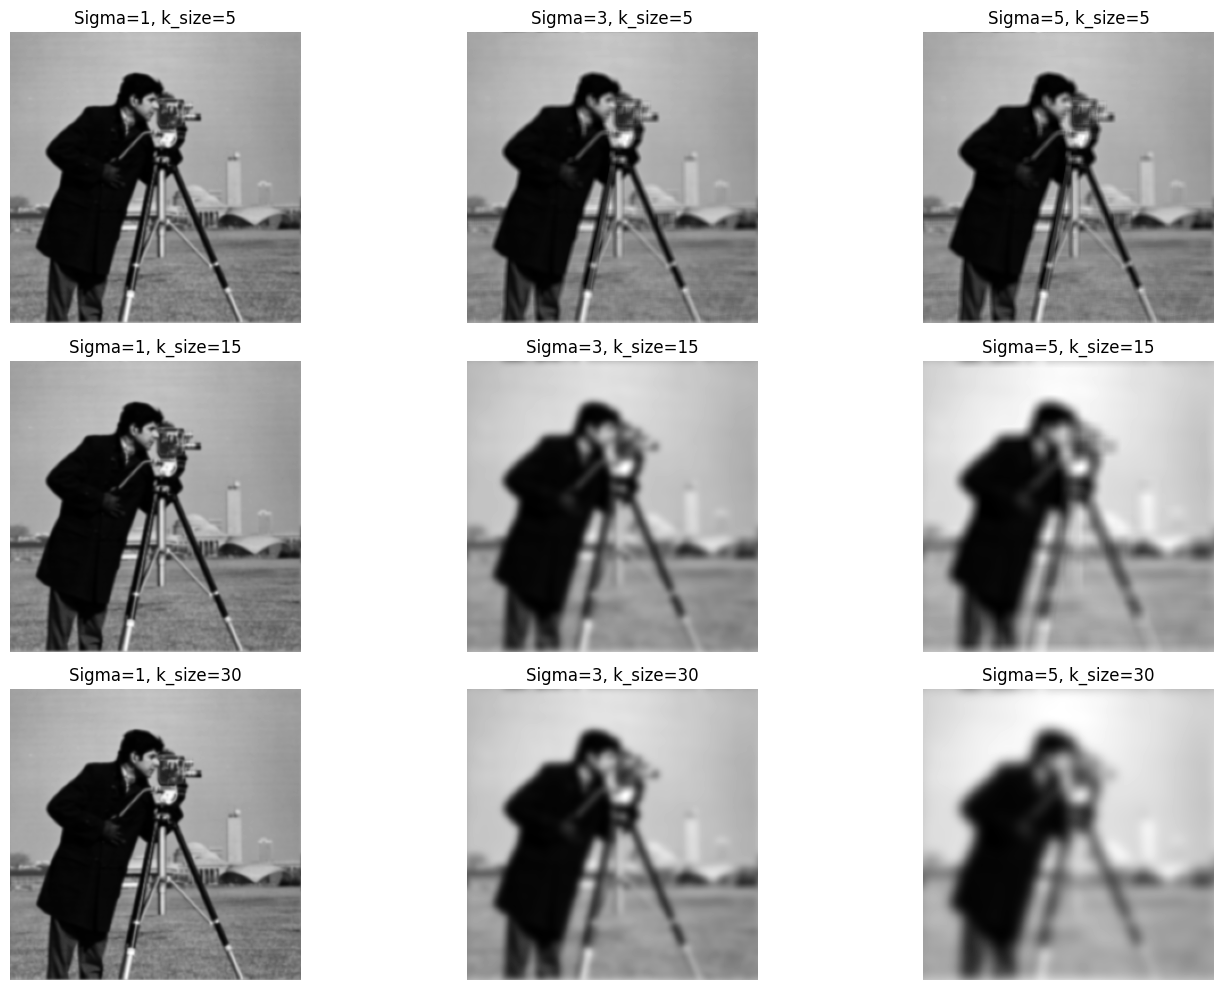

In [21]:
# Valores de k_sizes y sigmas
k_sizes = [5, 15, 30]
sigmas = [1, 3, 5]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 10))

# Aplicar el filtro gaussiano con diferentes k_sizes y sigmas
for i, k_size in enumerate(k_sizes):
    for j, sigma in enumerate(sigmas):
        # Crear el filtro gaussiano y su transformada de Fourier
        gauss_kernel, filter_frequency = create_gauss_filter(h, w, k_size, sigma)
        
        # Aplicar el filtro gaussiano a la imagen
        img_fft = np.fft.fft2(img)
        filtered = img_fft * filter_frequency
        img_filtered = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        
        # Mostrar la imagen original y la filtrada
        plt.subplot(len(k_sizes), len(sigmas), i * len(sigmas) + j + 1)
        plt.imshow(img_filtered, cmap='gray')
        plt.title(f'Sigma={sigma}, k_size={k_size}')
        plt.axis('off')

plt.tight_layout()
plt.show()

2. Usando el método descripto en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [22]:
def calculate_image_quality(image):
    # Paso 1: Calcular la transformada de Fourier de la imagen
    F = fft.fft2(image)

    # Paso 2: Desplazar el origen de F al centro
    Fc = fft.fftshift(F)

    # Paso 3: Calcular AF, el valor absoluto de la transformada centrada
    AF = np.abs(Fc)

    # Paso 4: Calcular el valor máximo de AF
    M = np.max(AF)

    # Paso 5: Calcular TH, el número total de píxeles en AF cuyo valor es mayor que thres
    thres = M / 1000
    TH = np.sum(AF > thres)

    # Paso 6: Calcular la medida de calidad de la imagen (FM)
    FM = TH / (image.shape[0] * image.shape[1])

    return FM

# Calcular la medida de calidad de la imagen en el dominio de la frecuencia
image_quality = calculate_image_quality(img)

print(f"Image quality measure (FM): {image_quality}")

Image quality measure (FM): 0.1204986572265625


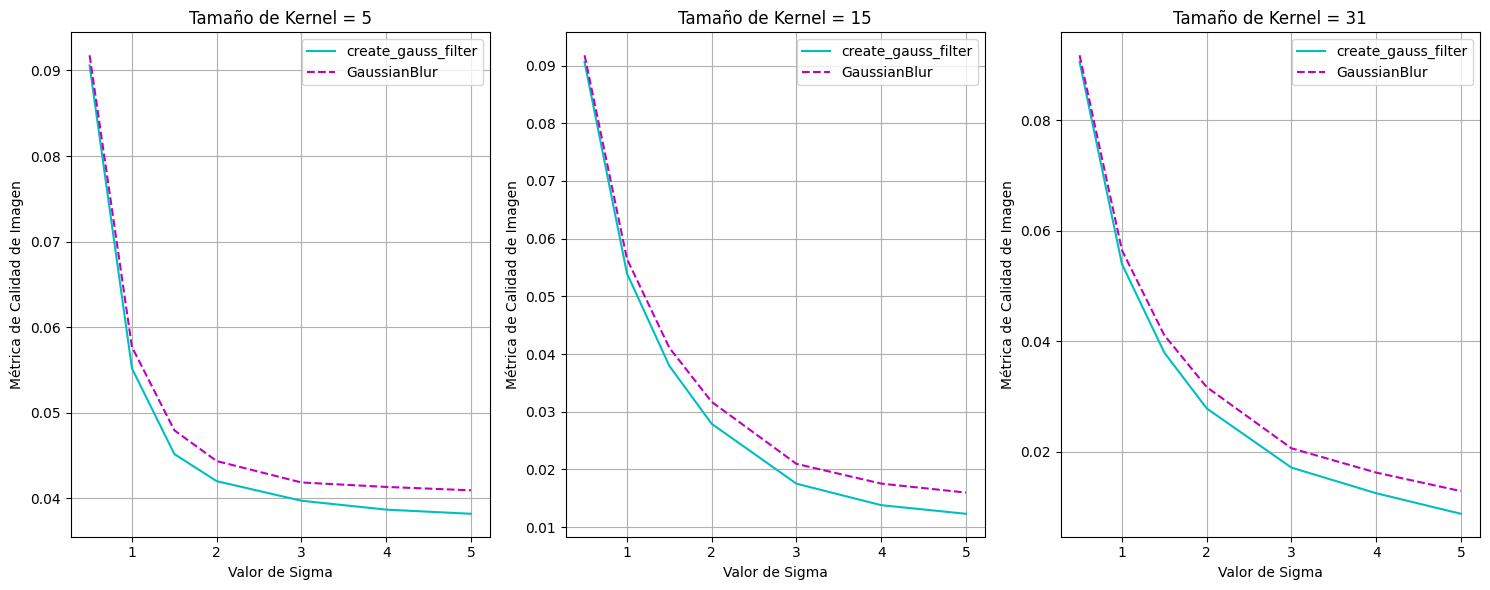

In [24]:
# Listas para almacenar las métricas de calidad de imagen para distintos tamaños de kernel y sigmas
metricas_create_gauss = []
metricas_gaussian_blur = []

# Distintos tamaños de kernel (k_sizes) y sigmas para probar
k_sizes = [5, 15, 31]
sigmas = [0.5, 1, 1.5, 2, 3, 4, 5]

# Redimensionar la imagen a una dimensión mayor para acomodar el tamaño de kernel más grande
if h < max(k_sizes) or w < max(k_sizes):
    nueva_h, nueva_w = max(h, max(k_sizes)), max(w, max(k_sizes))
    img = cv2.resize(img, (nueva_w, nueva_h))

# Aplicar create_gauss_filter con distintos tamaños de kernel y sigmas
for k_size in k_sizes:
    # Lista para almacenar las métricas de calidad para este tamaño de kernel
    metricas_k_size = []
    metricas_k_size_gaussian_blur = []
    
    for sigma in sigmas:
        # Crear el filtro gaussiano y su transformada de Fourier
        gauss_kernel, filter_frequency = create_gauss_filter(h, w, k_size, sigma)
        # Aplicar el filtro a la imagen usando el kernel gaussiano
        img_fft = np.fft.fft2(img)
        filtered = img_fft * filter_frequency
        img_filtrada = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

        # Aplicar el filtro a la imagen usando GaussianBlur
        img_filtrada_gaussian_blur = cv2.GaussianBlur(img, (k_size, k_size), sigma)
        
        # Calcular la métrica de calidad de imagen
        metrica_calidad = calculate_image_quality(img_filtrada)
        metrica_calidad_gaussian_blur = calculate_image_quality(img_filtrada_gaussian_blur)
        
        # Agregar la métrica a las listas
        metricas_k_size.append(metrica_calidad)
        metricas_k_size_gaussian_blur.append(metrica_calidad_gaussian_blur)
    
    # Agregar la lista de métricas para este tamaño de kernel a la lista general
    metricas_create_gauss.append(metricas_k_size)
    metricas_gaussian_blur.append(metricas_k_size_gaussian_blur)

# Graficar la comparación de las métricas de calidad de imagen para distintos valores de sigma
plt.figure(figsize=(15, 6))

for i, k_size in enumerate(k_sizes):
    plt.subplot(1, 3, i+1)
    plt.plot(sigmas, metricas_create_gauss[i], label='create_gauss_filter', color='c')
    plt.plot(sigmas, metricas_gaussian_blur[i], label='GaussianBlur', linestyle='--', color='m')
    plt.xlabel('Valor de Sigma')
    plt.ylabel('Métrica de Calidad de Imagen')
    plt.title(f'Tamaño de Kernel = {k_size}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”

In [26]:
def calculate_brenner_focus_measure(image):
    # Obtener las dimensiones de la imagen
    height, width = img.shape

    # Calcular la medida de enfoque de Brenner (MIS2)
    mis2_measure = 0
    for i in range(height-2):
        for j in range(width):
            mis2_measure += np.square(int(image[i, j]) - int(image[i+2, j]))

    return mis2_measure

# Calcular la medida de enfoque de Brenner (MIS2) para la imagen original
mis2_measure_original = calculate_brenner_focus_measure(img)
print(f"Brenner's Focus Measure (MIS2): {mis2_measure_original}")

Brenner's Focus Measure (MIS2): 44824830


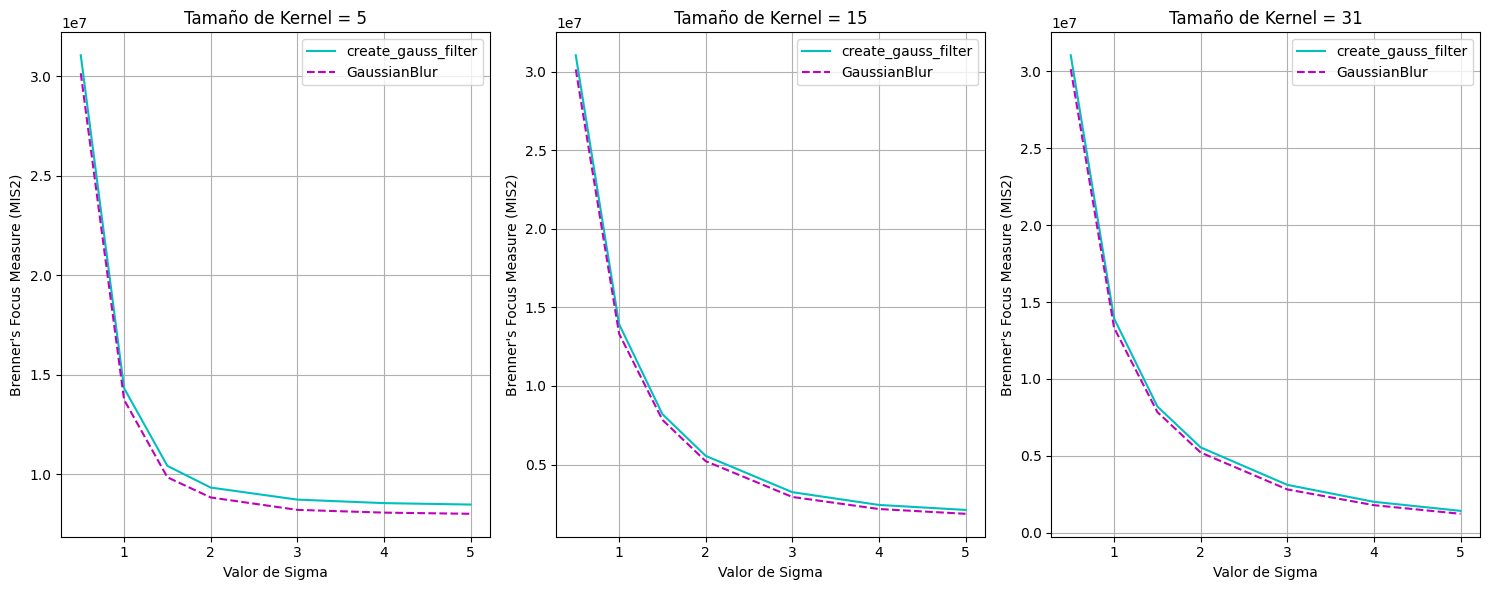

In [27]:
# Listas para almacenar las métricas de calidad de imagen para distintos tamaños de kernel y sigmas
metricas_create_gauss = []
metricas_gaussian_blur = []

# Distintos tamaños de kernel (k_sizes) y sigmas para probar
k_sizes = [5, 15, 31]
sigmas = [0.5, 1, 1.5, 2, 3, 4, 5]

# Redimensionar la imagen a una dimensión mayor para acomodar el tamaño de kernel más grande
if h < max(k_sizes) or w < max(k_sizes):
    nueva_h, nueva_w = max(h, max(k_sizes)), max(w, max(k_sizes))
    img = cv2.resize(img, (nueva_w, nueva_h))

# Aplicar create_gauss_filter con distintos tamaños de kernel y sigmas
for k_size in k_sizes:
    # Lista para almacenar las métricas de calidad para este tamaño de kernel
    metricas_k_size = []
    metricas_k_size_gaussian_blur = []
    
    for sigma in sigmas:
        # Crear el filtro gaussiano y su transformada de Fourier
        gauss_kernel, filter_frequency = create_gauss_filter(h, w, k_size, sigma)
        # Aplicar el filtro a la imagen usando el kernel gaussiano
        img_fft = np.fft.fft2(img)
        filtered = img_fft * filter_frequency
        img_filtrada = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

        # Aplicar el filtro a la imagen usando GaussianBlur
        img_filtrada_gaussian_blur = cv2.GaussianBlur(img, (k_size, k_size), sigma)
        
        # Calcular la métrica 
        metrica_calidad = calculate_brenner_focus_measure(img_filtrada)
        metrica_calidad_gaussian_blur = calculate_brenner_focus_measure(img_filtrada_gaussian_blur)
        
        # Agregar la métrica a las listas
        metricas_k_size.append(metrica_calidad)
        metricas_k_size_gaussian_blur.append(metrica_calidad_gaussian_blur)
    
    # Agregar la lista de métricas para este tamaño de kernel a la lista general
    metricas_create_gauss.append(metricas_k_size)
    metricas_gaussian_blur.append(metricas_k_size_gaussian_blur)

# Graficar la comparación de las métricas de calidad de imagen para distintos valores de sigma
plt.figure(figsize=(15, 6))

for i, k_size in enumerate(k_sizes):
    plt.subplot(1, 3, i+1)
    plt.plot(sigmas, metricas_create_gauss[i], label='create_gauss_filter', color='c')
    plt.plot(sigmas, metricas_gaussian_blur[i], label='GaussianBlur', linestyle='--', color='m')
    plt.xlabel('Valor de Sigma')
    plt.ylabel("Brenner's Focus Measure (MIS2)")
    plt.title(f'Tamaño de Kernel = {k_size}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()